# 3-1 프로야구 선수의 다음 해 연봉 예측하기

## 탐색: 프로야구 연봉 데이터 살펴보기

In [33]:
# -*- coding UTF-8 -*-
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
mpl.rc("font", family = "NanumGothic")

# Data Source : http://www.statiz.co.kr/
pitcher_file_path = "/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/picher_stats_2017.csv"
batter_file_path = "/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/batter_stats_2017.csv"
pitcher = pd.read_csv(pitcher_file_path)
batter = pd.read_csv(batter_file_path)

In [34]:
pitcher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [35]:
# 예측할 대상인 "연봉"에 대한 정보
pitcher["연봉(2018)"].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot: >

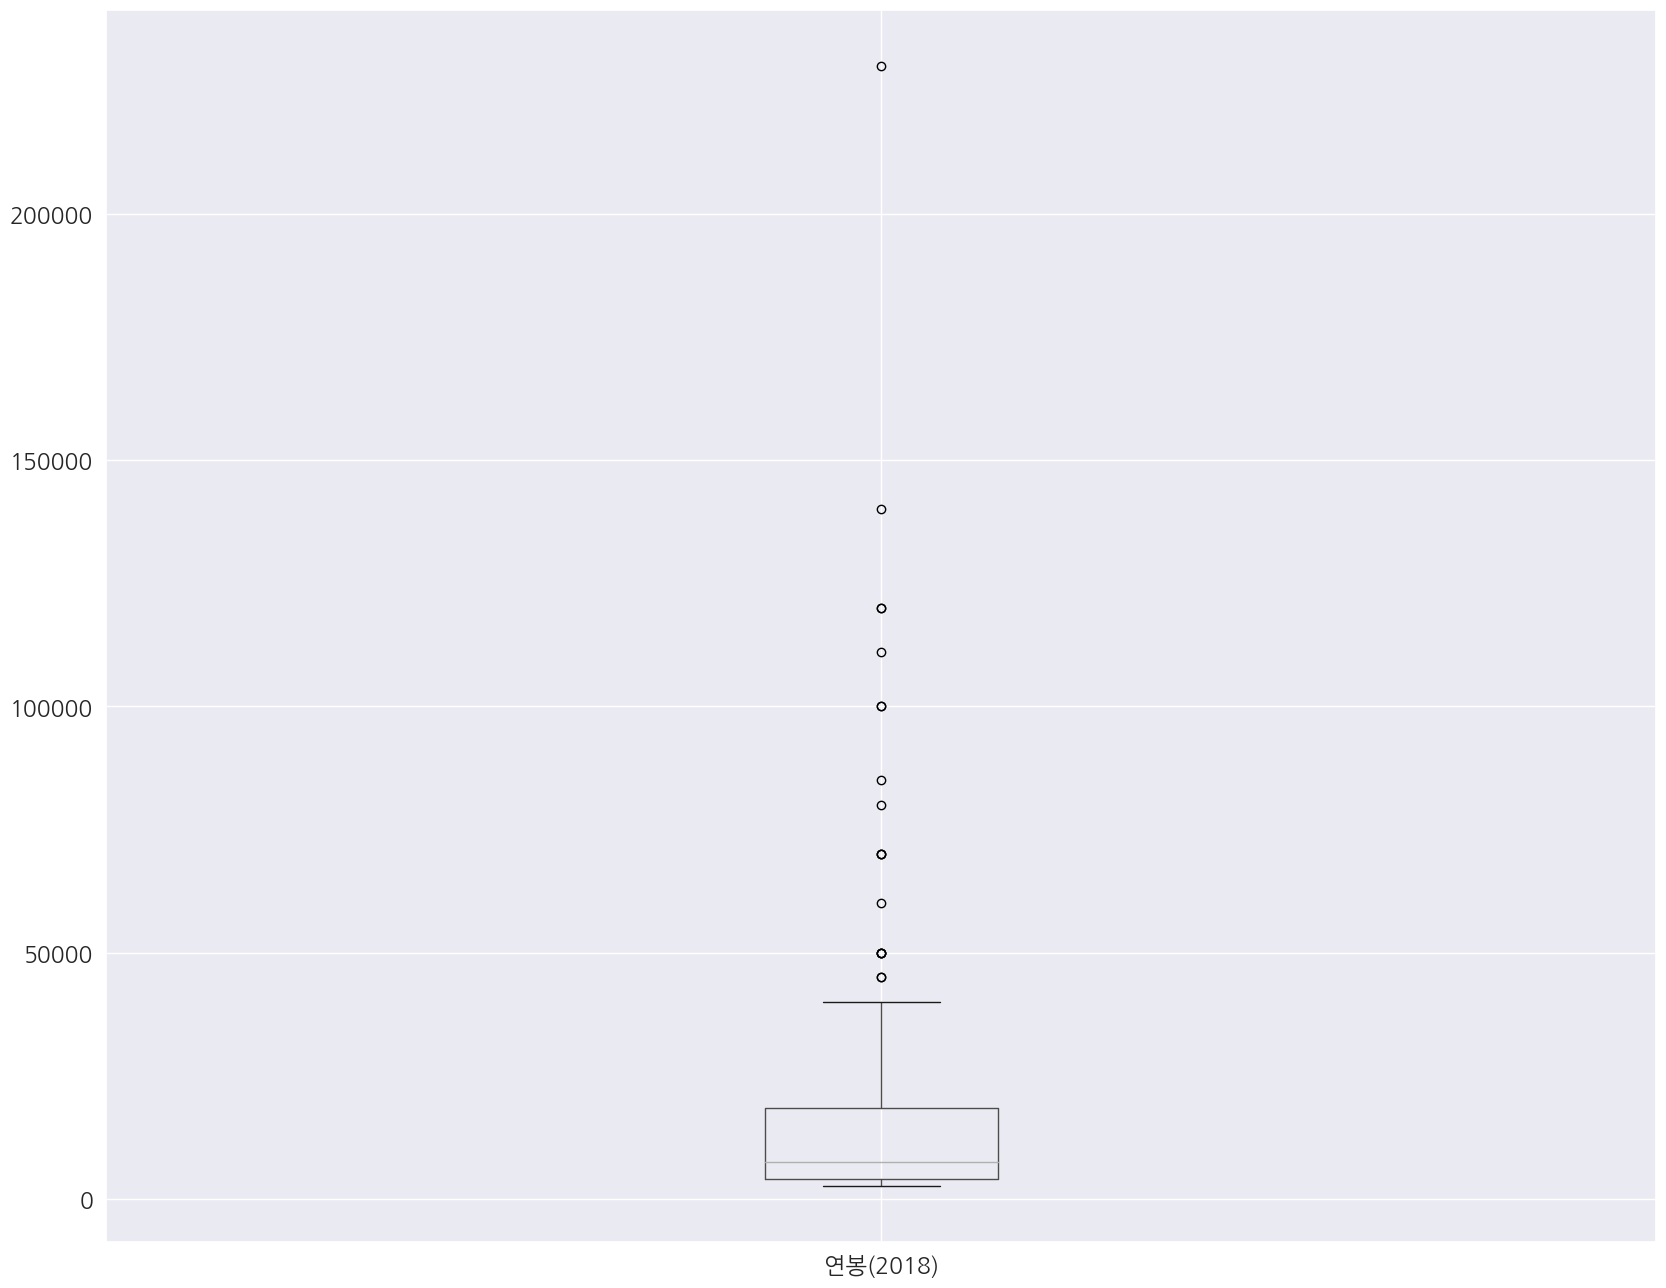

In [36]:
pitcher.boxplot(["연봉(2018)"])

<AxesSubplot: >

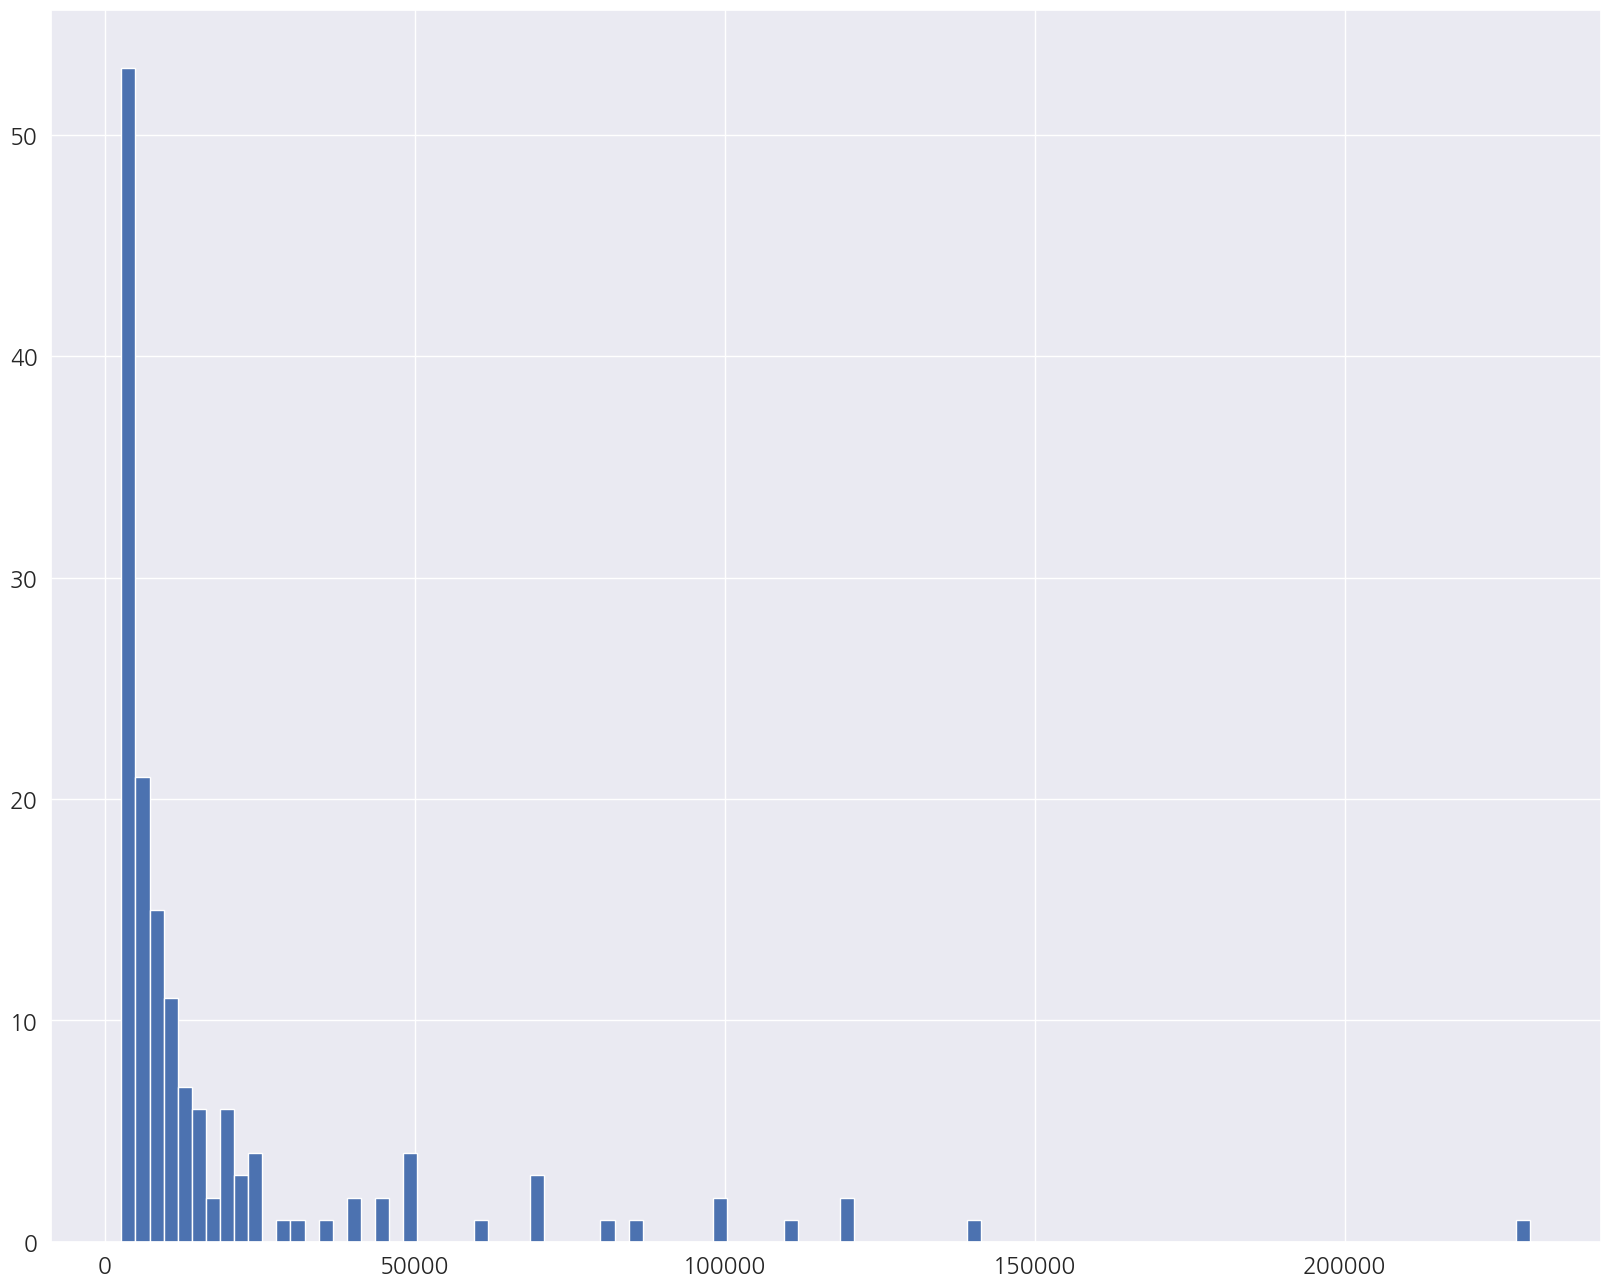

In [37]:
pitcher["연봉(2018)"].hist(bins = 100)

[회귀분석에 사용할 피처 살펴보기]

In [38]:
pitcher_features_df = pitcher.columns[2:].tolist()
pitcher_features_df = pitcher[pitcher_features_df[:]]
pitcher_features_df

# 피처 각각에 대한 히스토그램을 출력
def plot_hist_each_column(df):
    plt.rcParams["figure.figsize"] = [20, 16]
    fig = plt.figure(1)
    
    # df의 열 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i + 1)
        plt.hist(df[df.columns[i]], bins = 60)
        ax.set_title(df.columns[i])
    plt.show()

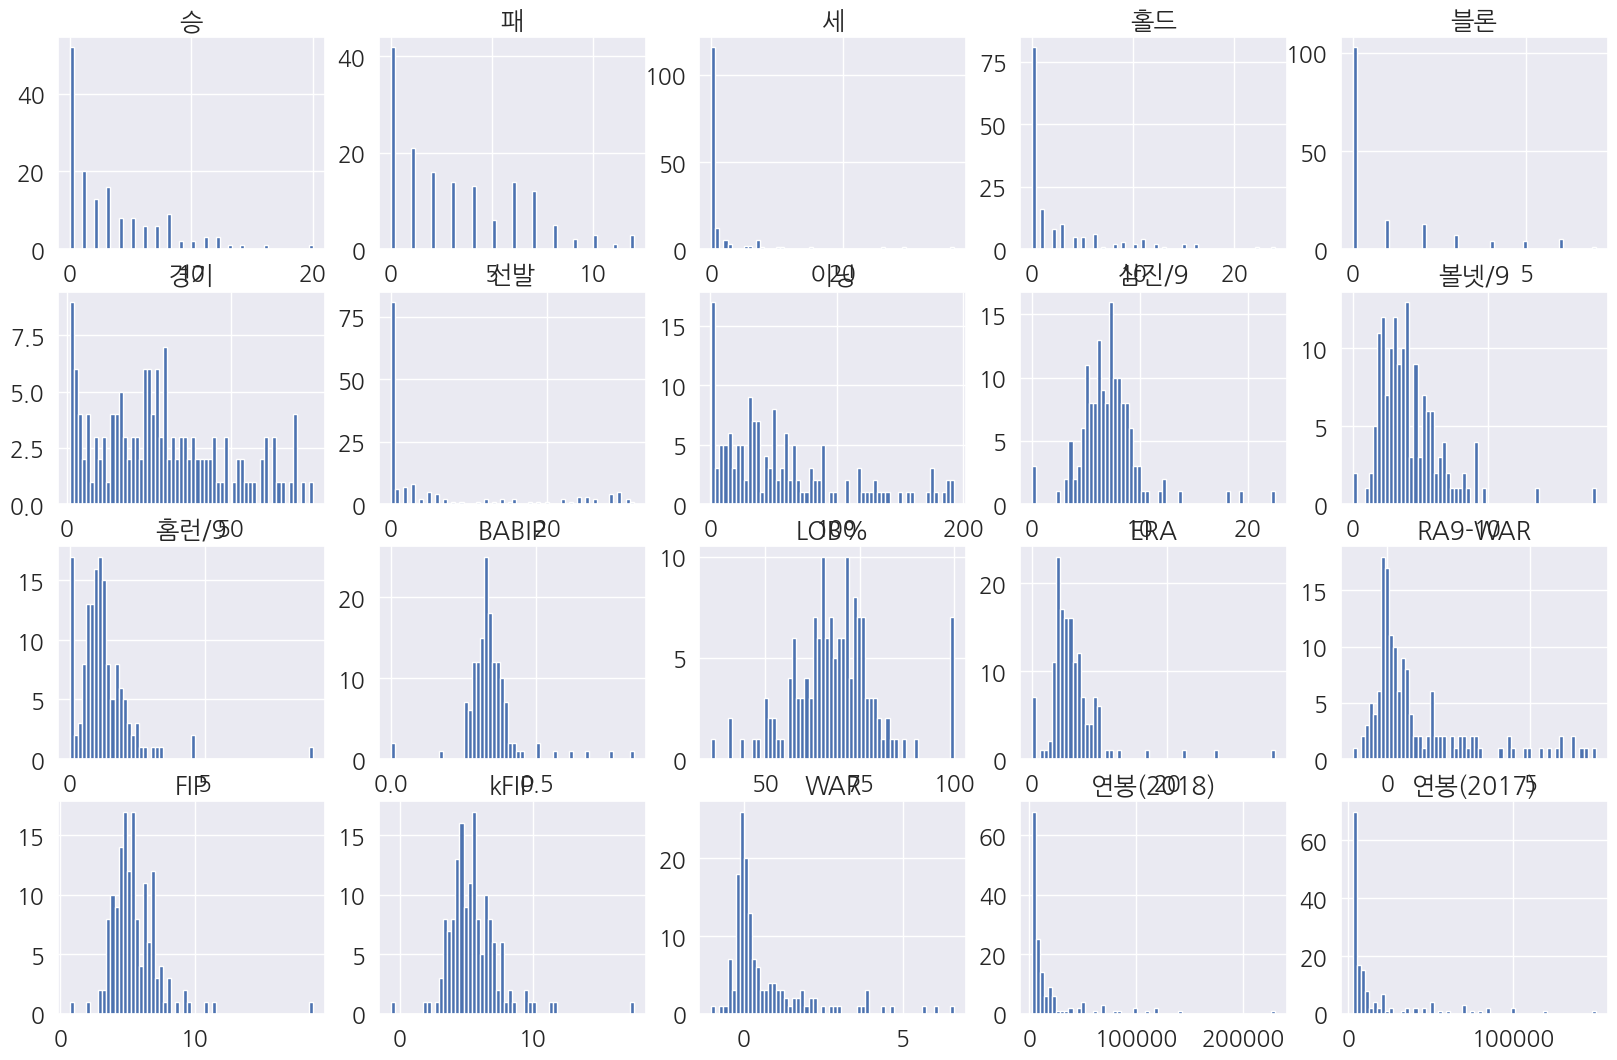

In [39]:
plot_hist_each_column(pitcher_features_df)

## 예측: 투수의 연봉 예측하기

[피처들의 단위 맞춰주기: 피처 스케일링]

In [40]:
# 판다스의 형태로 정의된 데이터를 출력할 때 scientific-notation이 아닌 float 모양으로 출력되게 해줌.
pd.options.mode.chained_assignment = None

In [41]:
# 피처 각각에 대한 스케일링을 수행하는 함수를 정의 z = (x - x바) / 표준편차 
def standard_scaling(df, *except_columns):
    for col in df.columns:
        for except_column in except_columns:
            if col == except_column:
                continue
            try:
                series_mean = df[col].mean()
                series_std = df[col].std()
                df[col] = df[col].apply(lambda x: (x - series_mean) / series_std)
            except:
                pass
    return df


# 피처 각각에 대한 스케일링을 수행
pitcher_df = standard_scaling(pitcher, "연봉(2018)")
pitcher_df = pitcher_df.rename(columns = {"연봉(2018)": "y"})
pitcher_df

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,한화,-0.309907,0.588357,-0.306452,-0.585705,0.680497,0.214300,-0.112010,0.104300,...,0.363854,0.162874,-1.002712,0.411349,-1.229537,0.375810,0.475992,-0.859111,7100,-0.335587
148,정용운,KIA,-0.051084,-0.369825,-0.306452,-0.585705,-0.543592,-0.198678,0.503369,0.042667,...,-0.147418,-0.871003,-0.269422,-0.030253,-0.361721,0.482702,0.622339,-0.874237,7500,-0.535215
149,노경은,롯데,-0.827554,-0.369825,-0.306452,-0.585705,-0.543592,-1.024633,-0.419699,-0.850019,...,1.219251,0.466294,-1.356417,1.347354,-1.023431,1.348527,1.389397,-0.964995,10000,-0.020173
150,김승현,삼성,-0.827554,-0.050431,-0.306452,-0.364245,-0.543592,0.627278,-0.624825,-0.273451,...,0.226204,0.005545,0.463869,-0.066253,-0.790205,0.728554,0.713175,-1.033063,4000,-0.543201


[피처들의 단위 맞춰주기: 원-핫 인코딩]

In [42]:
# 팀명 피처를 원-핫 인코딩으로 변환
team_encoding = pd.get_dummies(pitcher_df["팀명"])
pitcher_df = pitcher_df.drop("팀명", axis = 1)
pitcher_df = pitcher_df.join(team_encoding)
pitcher_df

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,-0.309907,0.588357,-0.306452,-0.585705,0.680497,0.214300,-0.112010,0.104300,-0.968896,...,-0.335587,0,0,0,0,0,0,0,0,1
148,정용운,-0.051084,-0.369825,-0.306452,-0.585705,-0.543592,-0.198678,0.503369,0.042667,-0.777918,...,-0.535215,1,0,0,0,0,0,0,0,0
149,노경은,-0.827554,-0.369825,-0.306452,-0.585705,-0.543592,-1.024633,-0.419699,-0.850019,-0.756699,...,-0.020173,0,0,0,0,0,0,1,0,0
150,김승현,-0.827554,-0.050431,-0.306452,-0.364245,-0.543592,0.627278,-0.624825,-0.273451,0.205264,...,-0.543201,0,0,0,0,0,0,0,1,0


[회귀분석을 위한 학습, 테스트 데이터셋 분리]

In [43]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리
x = pitcher_df[pitcher_df.columns.difference(["선수명", "y"])]
y = pitcher_df["y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 19)

[회귀 분석 계수 학습 & 학습된 계수 출력]

In [44]:
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.5564514    5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


## 평가: 예측 모델 평가하기

[어떤 피처가 가장 영향력이 강한 피처일까]

In [45]:
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           7.70e-42
Time:                        17:45:59   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e+04    697.967     24.036      0.000    1.54e+04    1.82e+04
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA          303.1852   2222.099      0.136      0.892   -4109.462    4715.833
KT          3436.0520   2133.084      1.611      0.111    -799.831    7671.935
LG          1116.9978   2403.317      0.465      0.643   -3655.513    5889.509
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1340.5004   2660.966      0.504      0.616   -3943.651    6624.652
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          2762.4237   2243.540      1.231      0.221   -1692.803    7217.650
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산           971.9293   2589.849      0.375      0.708   -4170.998    6114.857
롯데          2313.9585   2566.009      0.902      0.370   -2781.627    7409.544
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          -946.5092   2482.257     -0.381      0.704   -5875.780    3982.762
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          5477.8879   2184.273      2.508      0.014    1140.355    9815.421
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                     2.93e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

In [46]:
# 회귀 계수를 리스트로 반환
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)
print(coefs)
# 변수명을 리스트로 반환
x_labels = model.params.index.tolist()

[16776.425668089592, -1481.0173390074249, -416.6873660083795, -94136.23649208683, 303.18524487679633, 3436.0520183821623, 1116.9977725654142, -1375.538302892242, 1340.500420895778, 3959.106536605157, 2762.4236862978287, 10272.487464507176, 77672.53804468564, -2434.3894742675475, 971.9292836438547, 2313.9584680988946, 7612.156618121316, 1271.0450005899731, -946.5091549406504, 5396.972798960807, -4797.30275903849, -250.69773138835293, 236.0253005252398, 19130.590213567026, 854.0260458516823, 1301.6197463702974, 5477.887928270173, -935.0728179642487, 18144.60099744791]


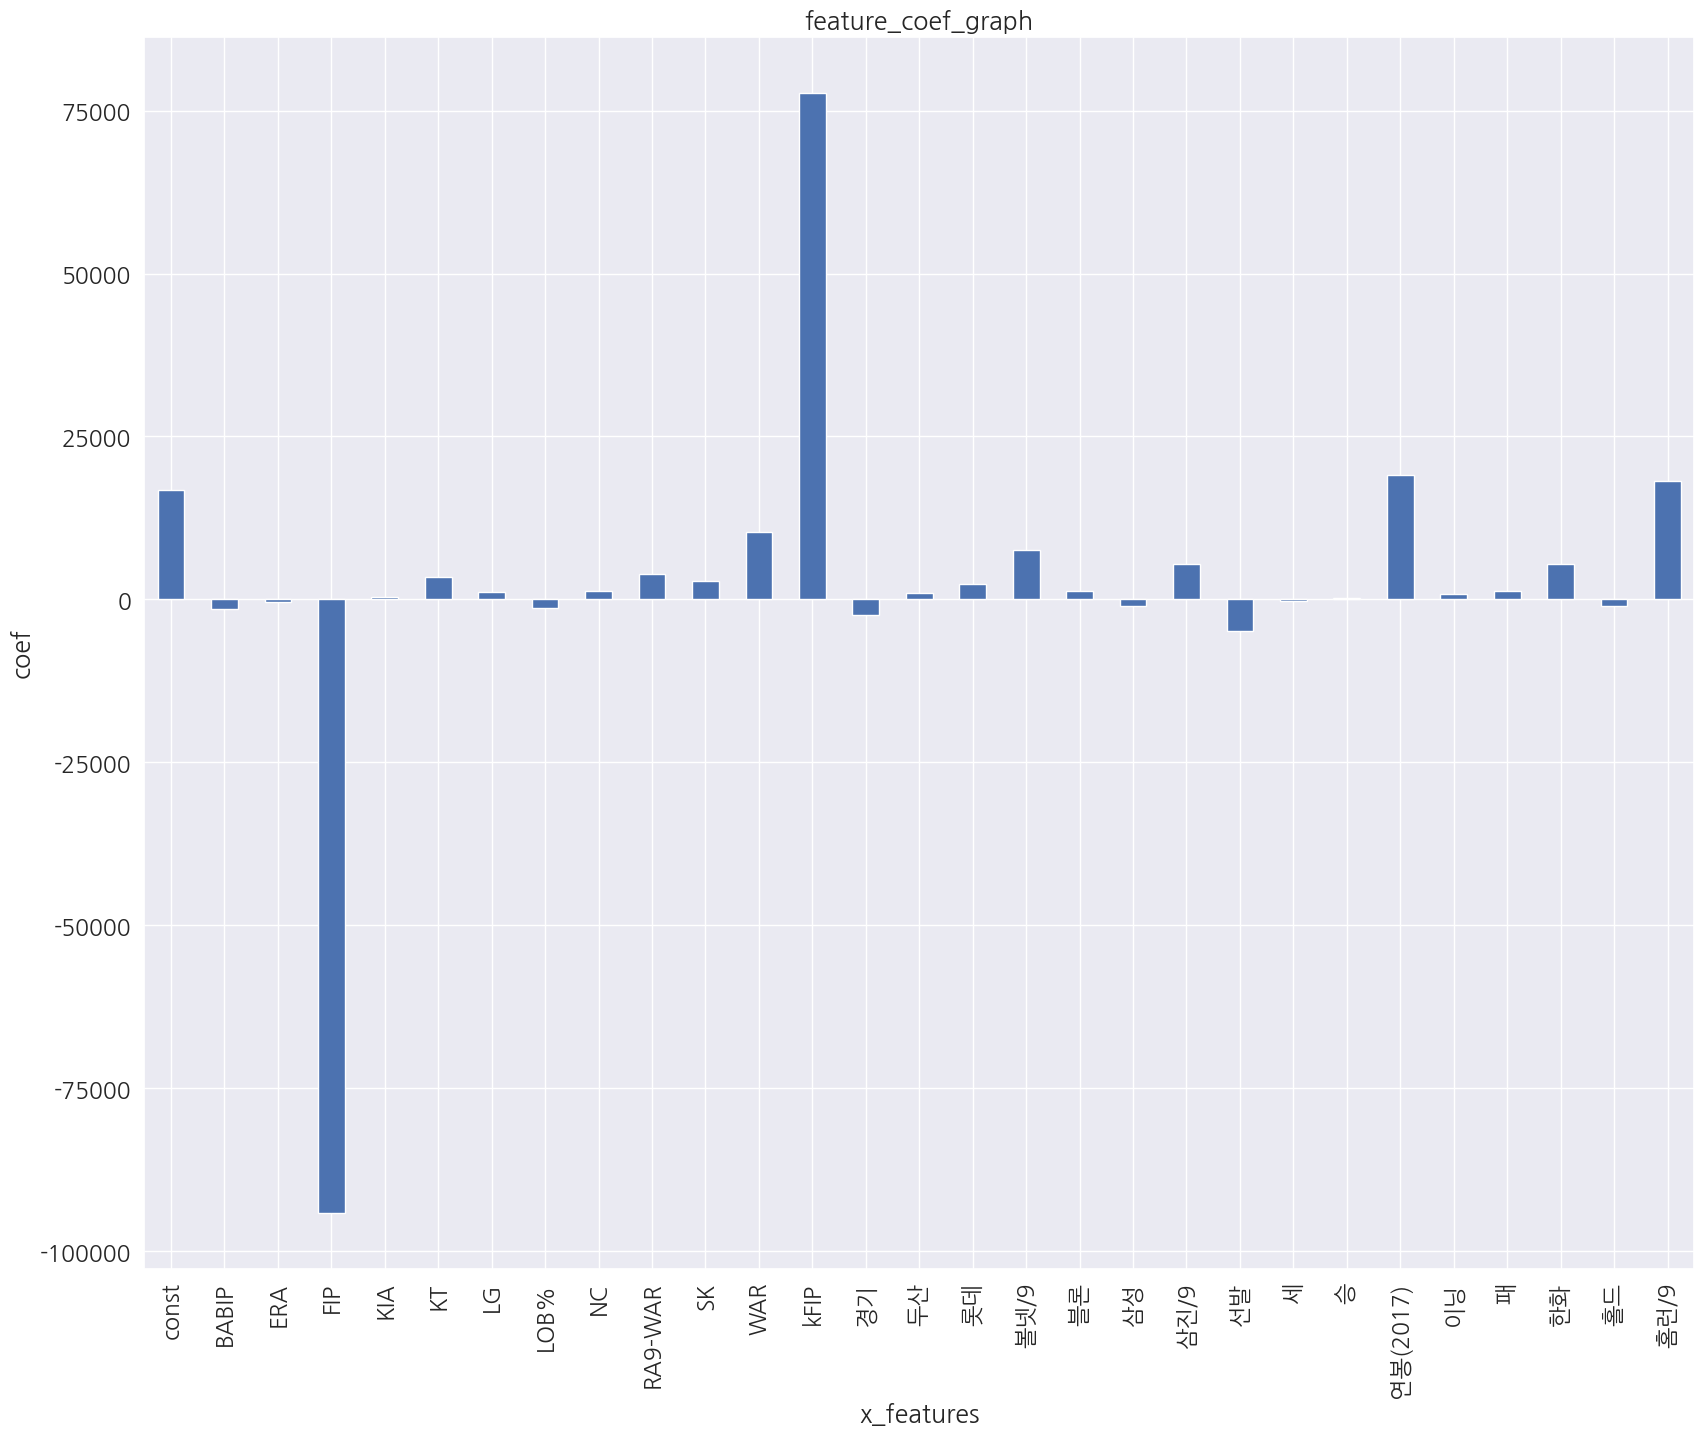

In [47]:
# 회귀 계수를 출력
ax = coefs_series.plot(kind = "bar")
ax.set_title("feature_coef_graph")
ax.set_xlabel("x_features")
ax.set_ylabel("coef")
ax.set_xticklabels(x_labels)

plt.show()

[예측 모델의 평가하기: R2 score]

In [48]:
# 학습 데이터와 테스트 데이터로 분리합니다.
x = pitcher_df[pitcher_df.columns.difference(["선수명", "y"])]
y = pitcher_df["y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 19)

# 회귀 분석 모델을 학습
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)

In [49]:
# 회귀 분석 모델을 평가(학습 데이터셋과 테스트 데이터셋에 대한 평가 점수)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.9276949405576705
0.8860171644977811


[예측 모델의 평가하기: RMSE score]

In [50]:
# 회귀 분석 모델을 평가(실제값과 예측값의 차이(오차))
y_train_predictions = lr.predict(x_train)
print(sqrt(mean_squared_error(y_train, y_train_predictions)))
y_test_predictions = lr.predict(x_test)
print(sqrt(mean_squared_error(y_test, y_test_predictions)))

7282.718684746373
14310.696436889173


[피처들의 상관 관계 분석하기]

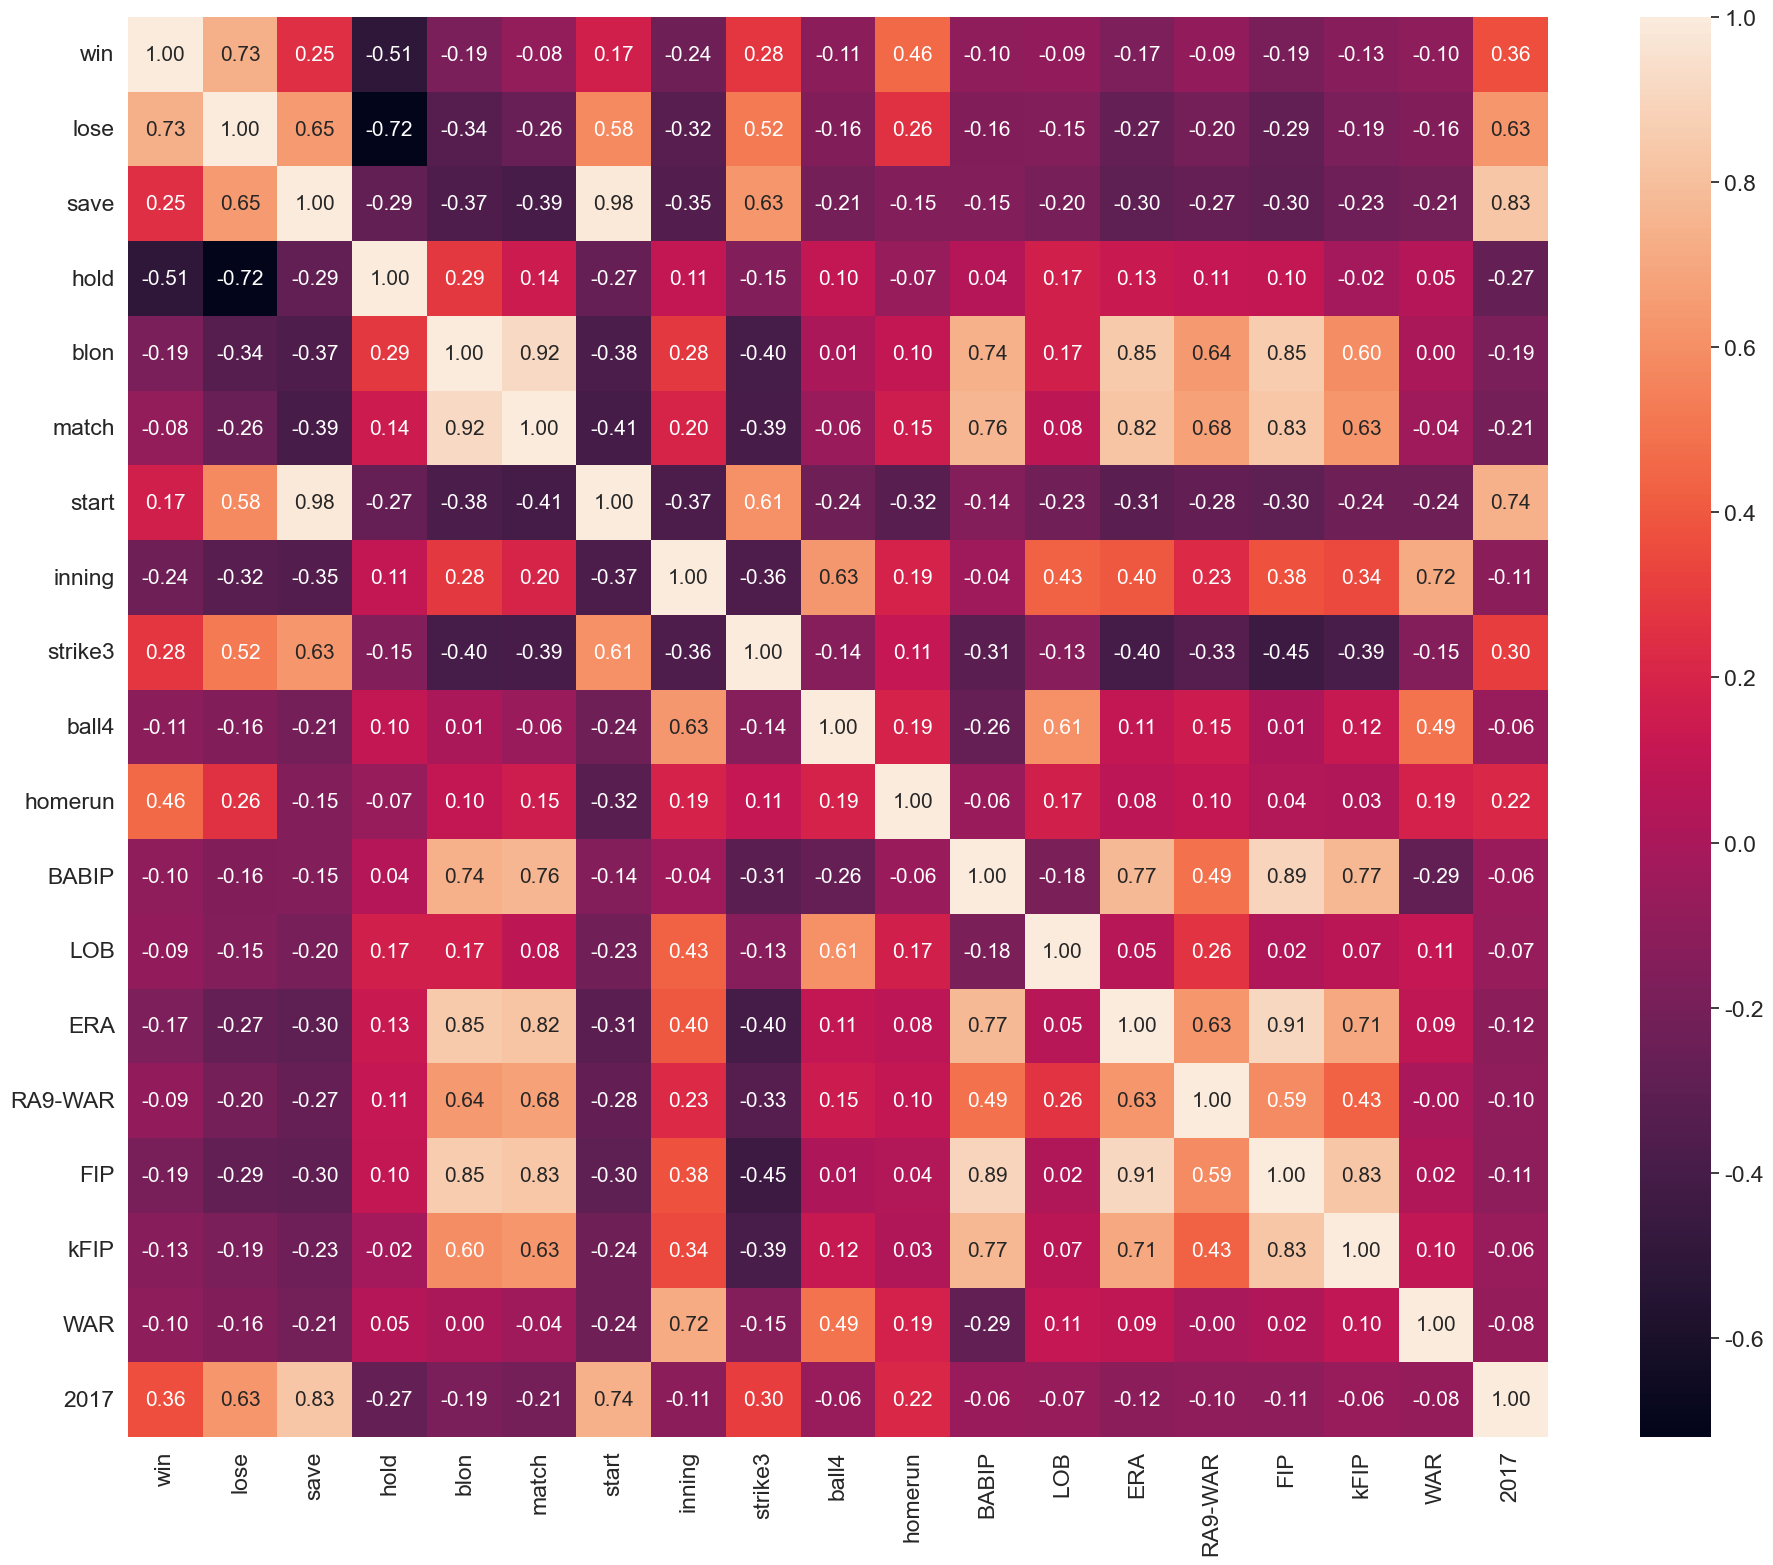

In [51]:
import seaborn as sns

# 피처 간의 상관계수 행렬을 계산
columns = pitcher.columns.difference(["선수명", "팀명", "연봉(2018)"]).tolist()
corr = pitcher_df[columns].corr(method = "pearson")
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 
             'inning', 'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 
             'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

# corr 행렬 히트맵을 시각화
sns.set(font_scale = 1.5)
hm = sns.heatmap(corr.values,
        cbar = True,
        annot = True,
        square = True,
        fmt = ".2f",
        annot_kws = {"size": 15},
        yticklabels = show_cols,
        xticklabels = show_cols)

plt.tight_layout()
plt.show()

[회귀 분석 예측 성능을 높이기 위한 방법: 다중 공선성 확인]  

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif

,VIF Factor,features
0,3.207869,BABIP
1,10.633696,ERA
2,14238.289281,FIP
3,1.109791,KIA
4,1.132708,KT
5,1.113030,LG
6,4.300985,LOB%
7,1.146670,NC
8,13.551449,RA9-WAR
9,1.144145,SK


[적절한 피처로 다시 학습하기]

In [53]:
# 피처를 재선정합니다.
# 최종적으로 train data와 test data의 오차를 줄이거나, test의 정확도를 최대한 올리는 쪽으로 결정하는 것이 좋음.
x = pitcher_df[["FIP", "WAR", "볼넷/9", "삼진/9", "연봉(2017)"]]
y = pitcher_df["y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 19)

In [54]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)

In [55]:
# 결과를 출력합니다.(R2 score)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.9150591192570362
0.9038759653889864


In [56]:
# 결과를 출력합니다.(RMSE score)
y_predictions = lr.predict(x_train)
print(sqrt(mean_squared_error(y_train, y_predictions)))
y_predictions = lr.predict(x_test)
print(sqrt(mean_squared_error(y_test, y_predictions)))

7893.462873347693
13141.866063591087


In [57]:
# 피처마다의 VIF 계수를 출력합니다.
x = pitcher_df[["FIP", "WAR", "볼넷/9", "삼진/9", "연봉(2017)"]]
vif = pd.DataFrame()
vif["VIF factors"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF factors,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


In [58]:
# 재선정된 모델들의 회귀분석 결과
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     247.8
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           7.89e-60
Time:                        17:46:01   Log-Likelihood:                -1257.5
No. Observations:                 121   AIC:                             2527.
Df Residuals:                     115   BIC:                             2544.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.87e+04    739.488     25.287      0.000    1.72e+04    2.02e+04
FIP          307.9658    994.849      0.310      0.757   -1662.638    2278.570
WAR         1.074e+04   1033.158     10.396      0.000    8694.257    1.28e+04
볼넷/9         713.2648    989.213      0.721      0.472   -1246.176    2672.705
삼진/9        -431.7822    725.815     -0.595      0.553   -1869.481    1005.917
연봉(2017)    1.984e+04   1044.493     18.998      0.000    1.78e+04    2.19e+04
==============================================================================
Omnibus:                       41.389   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              437.704
Skew:                          -0.702   Prob(JB):                     8.99e-96
Kurtosis:                      12.211   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 시각화: 분석 결과 시각화하기

[예측연봉과 실제연봉 비교하기]

In [59]:
# 2018년 연봉을 예측하여 데이터 프레임의 열로 생성
x = pitcher_df[["FIP", "WAR", "볼넷/9", "삼진/9", "연봉(2017)"]]
predict_2018_salary = lr.predict(x)
pitcher_df["예측연봉(2018)"] = pd.Series(predict_2018_salary)
print(pd.Series(predict_2018_salary))

0      120122.822204
1       88127.019455
2      163930.148696
3      116009.684582
4      102253.697589
           ...      
147      3080.623786
148      -395.321720
149      8896.091512
150     -2185.865106
151     -4560.315288
Length: 152, dtype: float64


In [60]:
# 원래의 데이터 프레임을 다시 불러옵니다.
pitcher = pd.read_csv("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/picher_stats_2017.csv")
pitcher = pitcher[["선수명", "연봉(2017)"]]

# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = pitcher_df.sort_values(by = ["y"], ascending = False)
result_df.drop("연봉(2017)", axis = 1, inplace = True, errors = "ignore")
result_df = result_df.merge(pitcher, on = ["선수명"], how = "left")
result_df = result_df[["선수명", "y", "예측연봉(2018)", "연봉(2017)"]]
result_df = result_df.rename(columns = {"연봉(2017)" : "작년연봉(2017)", "y" : "실제연봉(2018)"})

# 재계약하며 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df["작년연봉(2017)"] != result_df["실제연봉(2018)"]]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, ]
result_df

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


<AxesSubplot: xlabel='선수명'>

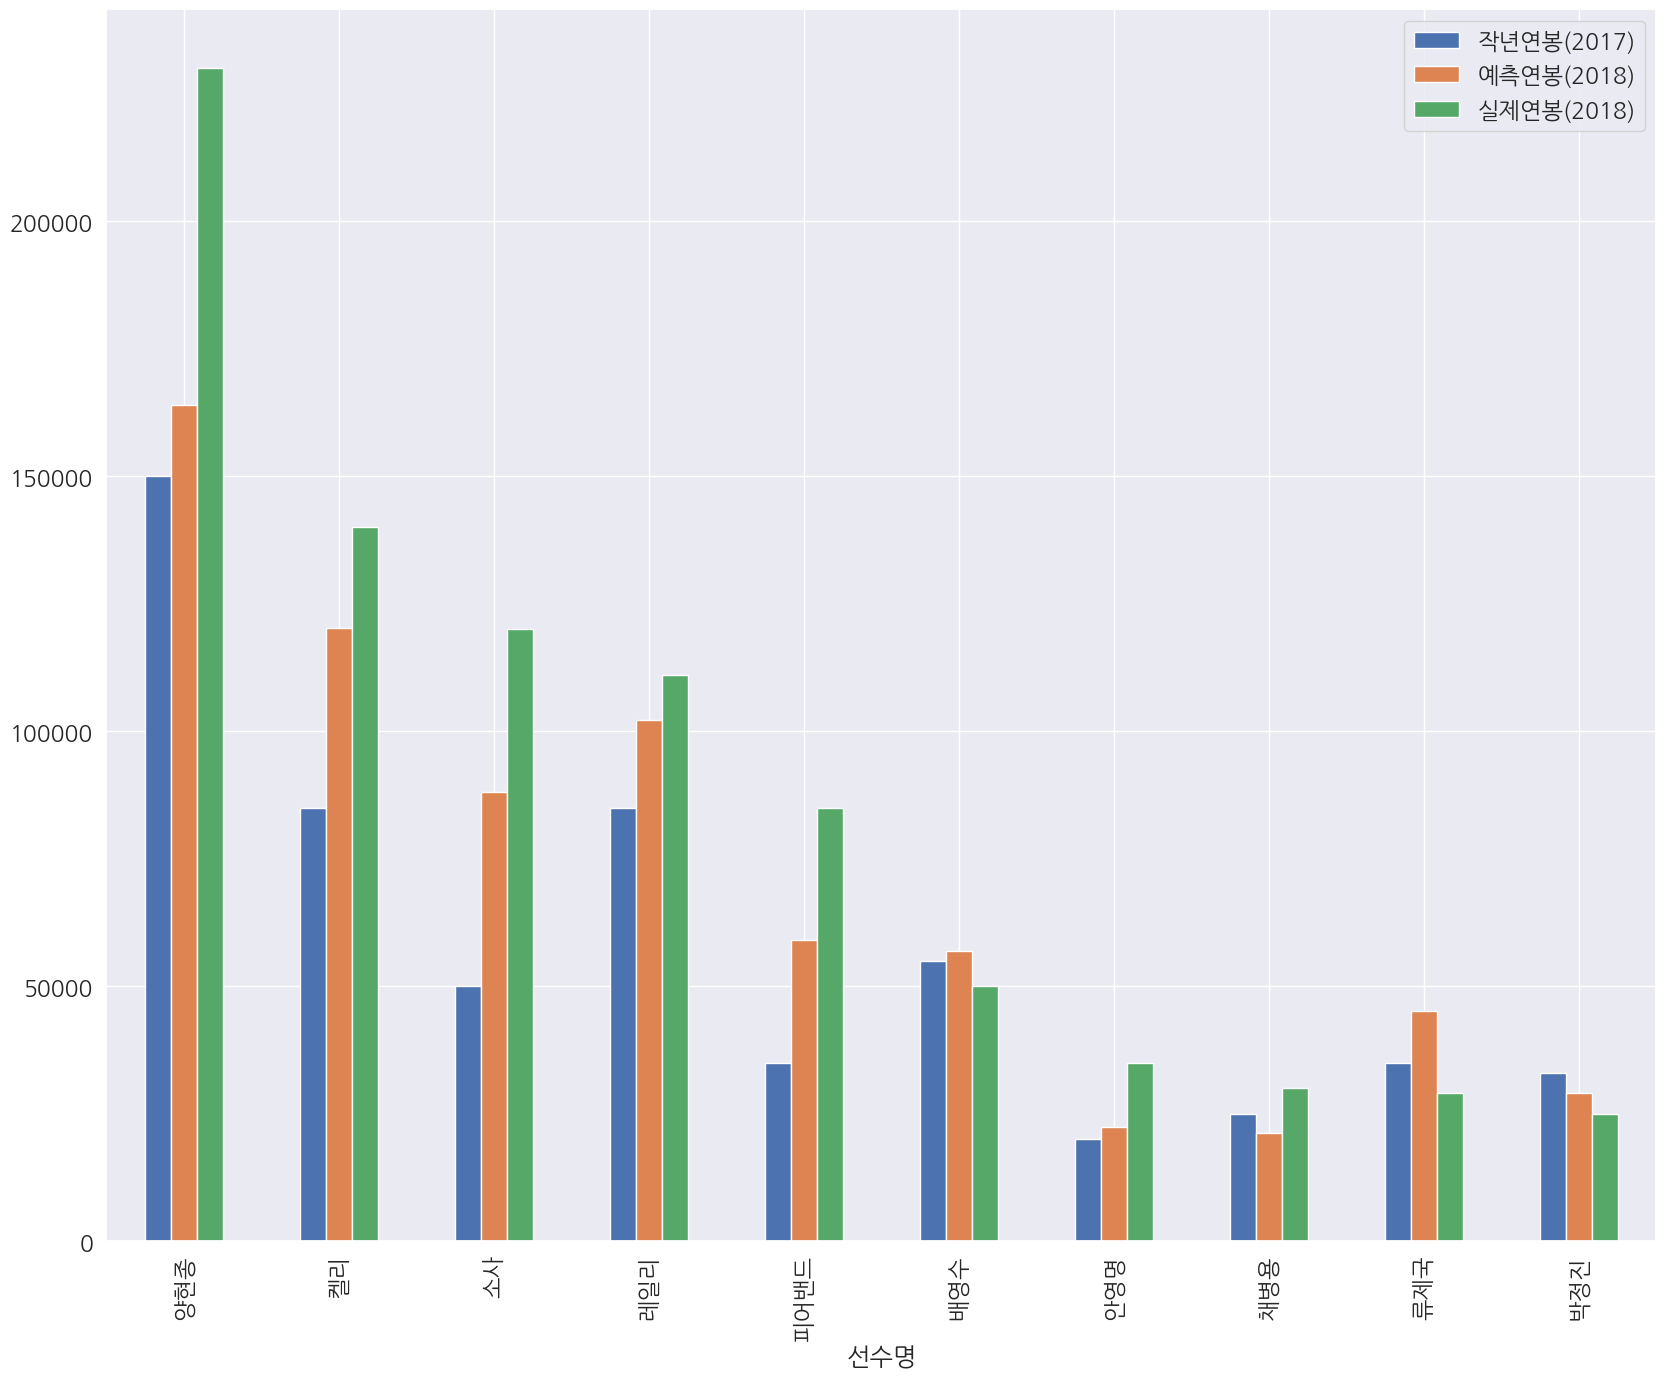

In [61]:
# 선수별 연봉 정보(작년연봉, 예측연봉, 실제연봉)를 막대 그래프로 출력
mpl.rc("font", family = "NanumGothic")
result_df.plot(x = "선수명", y = ["작년연봉(2017)", "예측연봉(2018)", "실제연봉(2018)"], kind = "bar")